# 1 - Imports e Setup $\sqrt{}$
$\alpha := 5 \%$ !!!

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import random as rd
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
sns.set_theme(context="notebook")
from tqdm import tqdm

# scipy.fft é melhor !
# https://stackoverflow.com/questions/6363154/what-is-the-difference-between-numpy-fft-and-scipy-fftpack
from scipy.fft import fft
from scipy.fftpack.helper import fftfreq

from scipy.stats import f as FDIST
from scipy.stats.distributions import chi2

In [2]:
# Calcula valor crítico em ORD qualquer, calculando quantil 95%
def vc_pratico(ORD, alpha = 0.05):
    return np.quantile(a= ORD, q = 1-alpha)

## 1.2 - Geração de sinais senoidais:

In [3]:
# ablsbalsblasa FFT, FFTFREQ, ETC

# 2 - Definições

## 2.1 - SFT: Spectral F-Test

### 2.1.1 - Definição e Funções

<img src = "sft.png"/>

In [4]:
def vc_SFT(L, alpha = 0.05, VERBOSE = 0):
    # valor crítico teórico, dado tomando inversa da distribuição acumulada F
    # (Fisher-Snedecor)
    # com significancia 1-alpha (95% se não for alterada)
    vc = FDIST.ppf(1-alpha, 2,2*L) 
    
    if VERBOSE==1:
        print('Significância desejada: ',alpha*100,'\b%')
    if VERBOSE==2:
        print('Significância desejada: ',alpha*100,'\b%')
        print('Valor crítico SFT: ',vc)

    return vc
        #fce999 TODO: perguntar por que 2 e 2*L!

def ord_SFT(sinal, L, BIN):
    # L: tamanho das laterais
    SINAL = fft(sinal)

    central = round(BIN) # certifica inteiro (não float)
    lateralMenor = round(central-L/2)
    lateralMaior = round(central+L/2)+1       

    DEN =np.abs(SINAL[central])**2
    SINAL_lateral = np.array(list(SINAL[lateralMenor:central])+list(SINAL[central+1:lateralMaior])) 
    NUM = (1/L)*np.sum(np.abs(SINAL_lateral)**2)
    SFT = DEN/NUM
    
    return [SINAL,SFT]

## 2.2 - CSM: Component Synchrony Measure 

### 2.2.1 - Definição e Funções: 

<img src = "csm.png"/>

In [5]:
def vc_CSM(M, alpha = 0.05, VERBOSE=0):
    vc = chi2.ppf(1-alpha,2)/(2*M)
    
    if VERBOSE==1:
        print('Significância desejada: ',alpha*100,'\b%')
    if VERBOSE==2:
        print('Significância desejada: ',alpha*100,'\b%')
        print('Valor crítico CSM: ',vc)

    return vc


def ord_CSM(sinal, tamanhoJanela, M):
    if len(sinal)-tamanhoJanela*M>=0:
        
        sinal = np.reshape(sinal[0:tamanhoJanela*M], (tamanhoJanela,M))


        FFT_SINAL = fft(sinal)

        CSM = (np.sum(np.cos(np.angle(FFT_SINAL)),axis=1)/M)**2 + (np.sum(np.sin(np.angle(FFT_SINAL)),axis=1)/M)**2

        return [FFT_SINAL,CSM]
    else:
        print('Erro no número de janelas', round(tamanhoJanela),'(ou amostras, M =', M,'\b) escolhido.')
        print('Tamanho do Sinal menos M*tamanhoJanela:', len(sinal)-M*tamanhoJanela)
        print('(Retorna 0)')
        return 0 

## 2.3 - MSC: Magnitude-Squared Coherence

### 2.3.1 - Definição e Funções

<img src = "msc.png"/>

In [6]:
def vc_MSC(M, alpha = 0.05, VERBOSE = 0):
    vc = 1-alpha**(1/(M-1))
    if VERBOSE==1:
        print('Significância desejada: ',alpha*100,'\b%')
    if VERBOSE==2:
        print('Significância desejada: ',alpha*100,'\b%')
        print('Valor crítico MSC: ',vc)
    return vc # valor crítico

def ord_MSC(sinal, tamanhoJanela, M):
    sinal = np.reshape(sinal[0:tamanhoJanela*M], (tamanhoJanela,M))

    SINAL = fft(sinal)
    
    MSC = (np.abs(np.sum(SINAL,axis=1))**2) / (M*np.sum(np.abs(SINAL)**2,axis=1))

    return [SINAL,MSC]

## 2.4 - Controle de significância (MSC)

### 2.4.1 - Definindo:

In [7]:
# Usando sequencial generalizado, queremos FP= 5% no teste GERAL! Qual deve ser FPi (cada iteração)?

def corrige_alfaMSC(
    tj = 100, # cada janela um segundo 
    Mmin = 10,
    Mstep = 10,
    Mmax = 60,
    BIN = 7,
    alphaD = 5/100,  #fff significancia a atingir
    alphaInicial = -1,
    tx_apr = 0.02,    # taxa de aprendizado
    nSim = 1e3, 
    itMAX = 300,
    VERBOSE = 1):

    print('\nCalculando alpha corrigido para alphaD =', alphaD)

    N = round(Mmax*tj)  # tamanho máximo do sinal
    nSim = round(nSim)  # numero de simulações
    if alphaInicial<0: alphas = [alphaD/(Mmax/Mstep)] # primeiro "chute" = alpha Desejado
    else: alphas = [alphaInicial]
    alphaR = 1   # significancia REAL
    it = 1  # iteração atual

    while alphaR > alphaD and it <= itMAX:
        if it>1:
            # Se J = mse = e^2 (univariado), então:
            grad = 2*alphaR - alphaD
            alphas.append(alphas[-1] -tx_apr*(grad))

        descricao = 'Iteração #'+str(it); it+=1; nd = 0; 
        
        if VERBOSE>=2:
            for _ in tqdm(range(1,nSim+1), leave=(VERBOSE>1), desc=descricao):
                x = rd.randn(N) # gera o "sinal" completo
                for M in range(Mmin, Mmax+Mstep,Mstep):
                    vc = vc_MSC(M,alpha=alphas[-1])            
                    [_, ORD]= ord_MSC(sinal=x, tamanhoJanela=tj, M=M)
                    if ORD[BIN]>vc: nd+=1

        if VERBOSE==1:
            for _ in tqdm(range(1,nSim+1), leave=False):
                x = rd.randn(N) # gera o "sinal" completo
                for M in range(Mmin, Mmax+Mstep,Mstep):
                    vc = vc_MSC(M,alpha=alphas[-1])            
                    [_, ORD]= ord_MSC(sinal=x, tamanhoJanela=tj, M=M)
                    if ORD[BIN]>vc: nd+=1

        else:
            for _ in range(1,nSim+1):
                x = rd.randn(N) # gera o "sinal" completo
                for M in range(Mmin, Mmax+Mstep,Mstep):
                    vc = vc_MSC(M,alpha=alphas[-1])            
                    [_, ORD]= ord_MSC(sinal=x, tamanhoJanela=tj, M=M)
                    if ORD[BIN]>vc: nd+=1

        alphaR = nd/(nSim*(Mmax/Mstep))


        if VERBOSE==3:
            print('Significancia atingida:',round(alphaR*100,ndigits=3),'\b%')
            print('Alpha corrigido:', round(alphas[-1],ndigits=3))

    if VERBOSE==1:
        print('Significancia atingida:',round(alphaR*100,ndigits=3),'\b%')
        print('Alpha corrigido:', round(alphas[-1],ndigits=4))
    
    if it>=itMAX: 
        print('Iteração máxima (',itMAX,') atingida!')
        print('Significancia alcançada:',round(alphaR*100,ndigits=3),'\b%')
        print('Retornando último valor de alpha corrigido: ', round(alphas[-1],ndigits=4))
    
    return alphas[-1]

# Exemplo:
print(corrige_alfaMSC(alphaD=0.04,VERBOSE=3))


Calculando alpha corrigido para alphaD = 0.04


Iteração #1: 100%|██████████| 1000/1000 [00:00<00:00, 1023.18it/s]


Significancia atingida: 5.117%
Alpha corrigido: 0.007


Iteração #2: 100%|██████████| 1000/1000 [00:00<00:00, 1282.05it/s]


Significancia atingida: 4.85%
Alpha corrigido: 0.005


Iteração #3: 100%|██████████| 1000/1000 [00:00<00:00, 1082.25it/s]


Significancia atingida: 3.85%
Alpha corrigido: 0.004
0.00428


# 3 - Validando meus resultados: 

## 3.1 - Validação teste da média:

In [8]:
# MC

## 3.2 - Validação vc_SFT:

### 3.2.1 - Validação do valor crítico:

In [12]:
# MC:
nSim = round(500) # numero de simulações
N = 500  # "duração" do sinal
bin = 50 # um bin qualquer
Ls = np.arange(2,30,1)   # tamanho qualquer 
x = np.zeros((N,))
vcp = np.zeros((nSim,len(Ls)))
vct = np.zeros((nSim,len(Ls)))
oo = np.zeros((nSim,))

for ll in tqdm(range(0,len(Ls)), desc='Simulando'):
    for ii in range(0,nSim):
        x = rd.randn(N,)
        [X,ORD] = ord_SFT(sinal=x, L=Ls[ll], BIN= bin)
        oo[ii] = ORD
        vct[ii][ll] = vc_SFT(Ls[ll])
    
    vcp[ll] = vc_pratico(oo) # alpha definido a 5%

print('Pronto')

Simulando: 100%|██████████| 28/28 [00:02<00:00, 10.55it/s]

Pronto


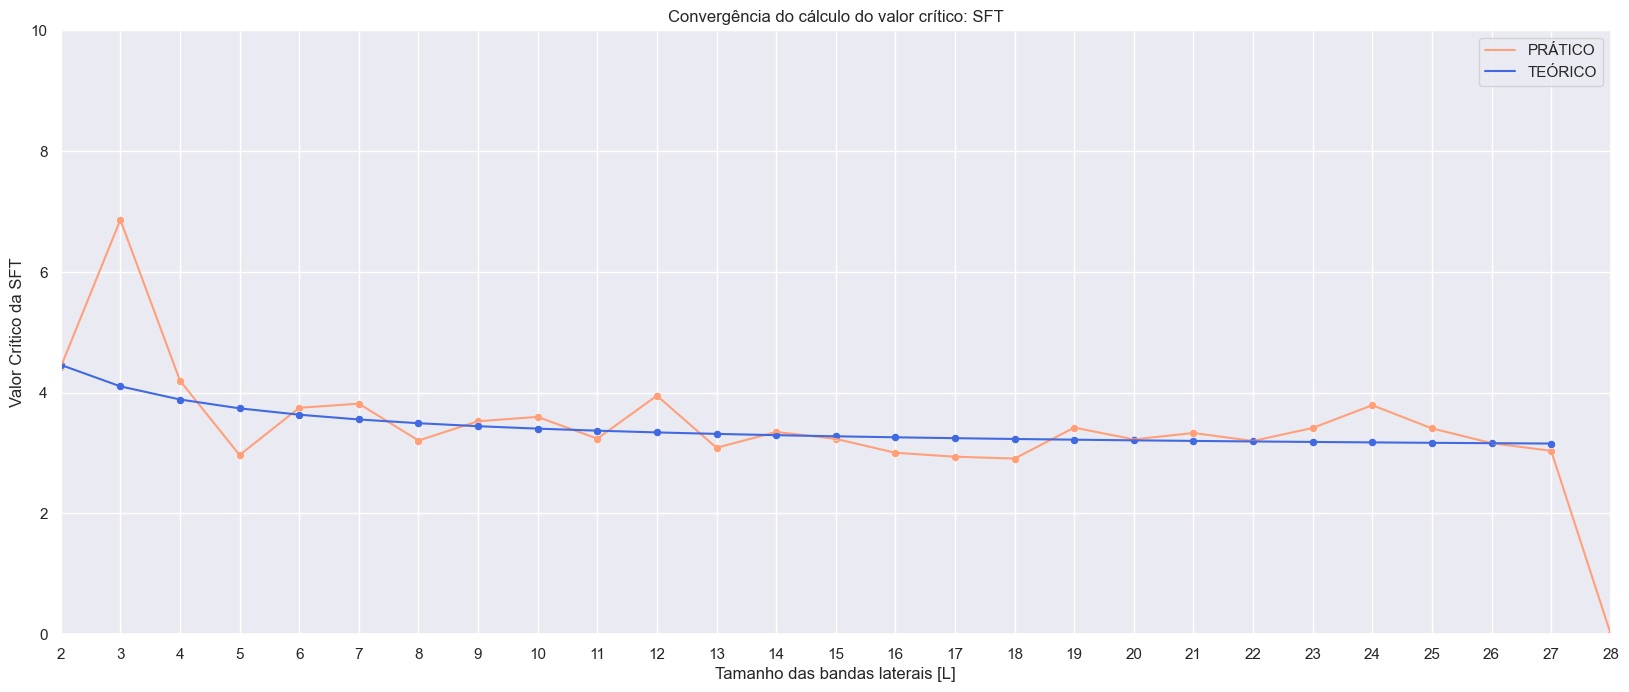

In [13]:
# print(np.mean(vcp,axis=1))
p = sns.lineplot(data = np.mean(vcp,axis=1), color = 'lightsalmon') 
p = sns.lineplot(data = np.mean(vct,axis=0), color = 'royalblue') 

plt.xticks(np.arange(0,max(Ls),1));
plt.xlim([2, max(Ls)-1]);
plt.ylim([0,10]);
plt.title('Convergência do cálculo do valor crítico: SFT');
plt.ylabel('Valor Crítico da SFT');
plt.xlabel('Tamanho das bandas laterais [L]');

sns.scatterplot(data = np.mean(vcp,axis=1), color = 'lightsalmon'); 
sns.scatterplot(data = np.mean(vct,axis=0), color = 'royalblue'); 
plt.legend(['PRÁTICO','TEÓRICO']);

### 3.2.2 - Validação MC SFT:

## 3.3 Validação CSM:

### 3.3.1 - Validação do valor crítico:

### 3.3.2 - Validação MC CMS: